# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import csv
from scipy import stats
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)


604

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
url = "http://api.openweathermap.org/data/2.5/weather"
units = 'metric'
rows = []
# create a counter
counter = 1

query_url = f"{url}?appid={weather_api_key}&units={units}&q="

for city in cities:
    response = requests.get(query_url + city).json()
    try:
        print(f'Processing record # {counter} for {city}')
        # add 1 to the record count
        counter += 1
        # add lat/lon/max temp etc to the created lists.  
        
        lat = response['coord']['lat']
        lon = response['coord']['lon']
        max_temp = response['main']['temp_max']
        humidity = response['main']['humidity']
        cloud = response['clouds']['all']
        wind_speed = response['wind']['speed']
        country = response['sys']['country']
        date = response['dt']
        
    except KeyError:
        print(f'City not found. Skipping...')
                      
    else:
        #these records only get appended if the above tests succeed. 
        #If we don't do this, partial records might be created which will give a ValueError(arrays must be the same length) later.
        #Get around this issue by creating rows where each row is its own dictionary.
        row_dict = {'City': city,
                    'Latitude': lat,
                    'Longitude': lon,
                    'Max Temp': max_temp,
                    'Humidity': humidity,
                    'Cloudiness': cloud,
                    'Wind Speed': wind_speed,
                     'Country': country,
                     'Date': date
                    }
        rows.append(row_dict)

Processing record # 1 for cuiluan
Processing record # 2 for shingu
Processing record # 3 for hithadhoo
Processing record # 4 for vaini
Processing record # 5 for mudyuga
City not found. Skipping...
Processing record # 6 for ayan
Processing record # 7 for tual
Processing record # 8 for illoqqortoormiut
City not found. Skipping...
Processing record # 9 for barrow
Processing record # 10 for nuuk
Processing record # 11 for cehegin
Processing record # 12 for okhotsk
Processing record # 13 for locri
Processing record # 14 for encruzilhada
Processing record # 15 for hami
Processing record # 16 for mushie
Processing record # 17 for rikitea
Processing record # 18 for fortuna
Processing record # 19 for marzuq
Processing record # 20 for east london
Processing record # 21 for khatanga
Processing record # 22 for port alfred
Processing record # 23 for port elizabeth
Processing record # 24 for marv dasht
City not found. Skipping...
Processing record # 25 for bluff
Processing record # 26 for carnarvon


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
weather_new_df = pd.DataFrame(rows)

In [5]:
weather_new_df.to_csv(output_data_file,index=False)

In [6]:
# Read our data back from the csv file we created so we don't have to re-run the api pull each time the file is opened.
cities_date_df = pd.read_csv(output_data_file)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
cities_date_df.set_index('City')

,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City,,,,,,,,
cuiluan,47.7200,128.6480,-27.53,84,0,0.52,CN,1612050579
shingu,33.7333,135.9833,7.00,76,75,6.17,JP,1612050427
hithadhoo,-0.6000,73.0833,27.56,79,65,6.73,MV,1612050579
vaini,-21.2000,-175.2000,29.00,84,75,5.14,TO,1612049830
ayan,56.4500,138.1667,-21.90,85,100,3.04,RU,1612050018
...,...,...,...,...,...,...,...,...
evinayong,1.4368,10.5512,20.35,97,100,1.60,GQ,1612050723
kuala kedah,6.1000,100.3000,23.00,88,20,1.54,MY,1612050723
svetlaya,46.5389,138.3297,-17.04,81,94,4.38,RU,1612050457


In [8]:
#  Get the indices of cities that have humidity over 100%.
humid_df = cities_date_df.loc[cities_date_df['Humidity']>100]
humid_df.head()

,City,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date


In [9]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data_df = cities_date_df.drop(cities_date_df[cities_date_df['Humidity']>100].index, inplace=False)

In [10]:
# Extract relevant fields from the data frame
# Export the City_Data into a csv
clean_city_data_df.to_csv('cities_clean.csv', index= False)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

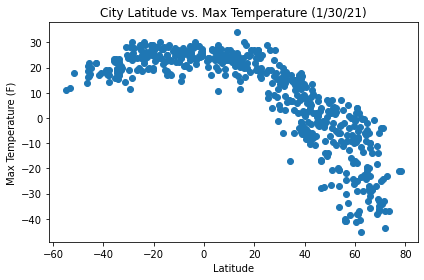

In [43]:
today_date = '1/30/21'
plt.scatter(clean_city_data_df['Latitude'],clean_city_data_df['Max Temp'])
plt.title(f'City Latitude vs. Max Temperature ({today_date})')
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.tight_layout()
plt.savefig("Lat_vs_Max_Temp.png")
plt.show()

## Latitude vs. Humidity Plot

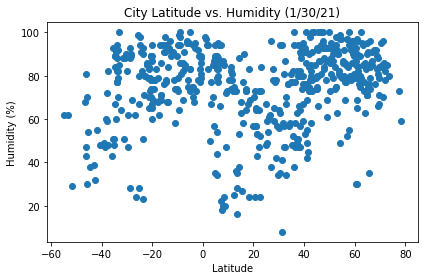

In [44]:
plt.scatter(clean_city_data_df['Latitude'],clean_city_data_df['Humidity'])
plt.title(f'City Latitude vs. Humidity ({today_date})')
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.tight_layout()
plt.savefig("Lat_vs_Humidity.png")
plt.show()

## Latitude vs. Cloudiness Plot

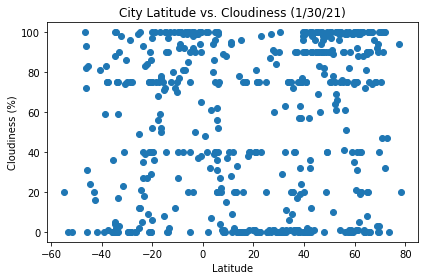

In [45]:
plt.scatter(clean_city_data_df['Latitude'],clean_city_data_df['Cloudiness'])
plt.title(f'City Latitude vs. Cloudiness ({today_date})')
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.tight_layout()
plt.savefig("Lat_vs_Cloudiness.png")
plt.show()

## Latitude vs. Wind Speed Plot

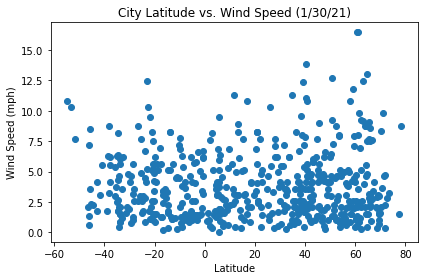

In [46]:
plt.scatter(clean_city_data_df['Latitude'],clean_city_data_df['Wind Speed'])
plt.title(f'City Latitude vs. Wind Speed ({today_date})')
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.tight_layout()
plt.savefig("Lat_vs_Wind_Speed.png")
plt.show()

## Linear Regression

In [64]:
# OPTIONAL: Create a function to create Linear Regression plots
# Test version for Cloudiness vs latitude

# create test variables for our function
x_values = clean_city_data_north_df['Latitude']
y_values = clean_city_data_north_df['Cloudiness']
title = f'Northern Hemisphere: Cloudiness vs Latitude ({today_date})'
xlabel = 'Latitude'
ylabel = 'Cloudiness'
annotate_x = 40
annotate_y = 40
fontsize = 15
color = 'red'

# define the function and accept our variables.
def weather_reg(x_values, y_values, title, xlabel, ylabel, annotate_x, annotate_y, fontsize, color):
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
    regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
    plt.annotate(line_eq,(annotate_x,annotate_y),fontsize=15,color="red")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    print(f"The r-squared is: {rvalue**2}")
    plt.show()

The r-squared is: 0.0687521570645846


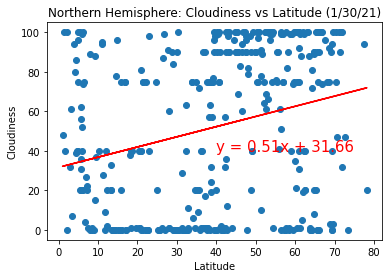

In [66]:
# Display of our test function using the Cloudiness vs Latitude variables above
weather_reg(x_values, y_values, title, xlabel, ylabel, annotate_x, annotate_y, fontsize, color)

In [48]:
# Create Northern and Southern Hemisphere DataFrames. Define northern hemisphere as latitude > 0 degrees and southern hemisphere as latitude < 0 degrees.
clean_city_data_north_df = clean_city_data_df.loc[clean_city_data_df['Latitude']>0]
clean_city_data_south_df = clean_city_data_df.loc[clean_city_data_df['Latitude']<0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7193164743428975


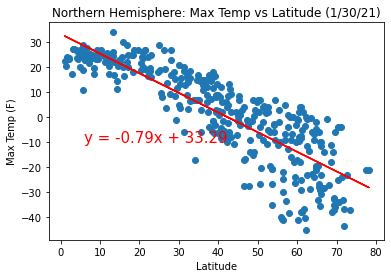

In [49]:
# The graph below shows a fairly strong negative relationship between max temp and latitude in the norther hemisphere
x_values = clean_city_data_north_df['Latitude']
y_values = clean_city_data_north_df['Max Temp']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
plt.annotate(line_eq,(6,-10),fontsize=15,color="red")
plt.title(f'Northern Hemisphere: Max Temp vs Latitude ({today_date})')
plt.xlabel('Latitude')
plt.ylabel('Max Temp (F)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.3144893108774404


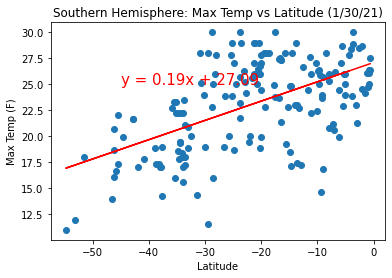

In [50]:
# There are fewer points (less population in the southern hemisphere) but a reasonable positive relationship between latitude and max temp.
x_values = clean_city_data_south_df['Latitude']
y_values = clean_city_data_south_df['Max Temp']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
plt.annotate(line_eq,(-45,25),fontsize=15,color="red")
plt.title(f'Southern Hemisphere: Max Temp vs Latitude ({today_date})')
plt.xlabel('Latitude')
plt.ylabel('Max Temp (F)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.1171191448875093


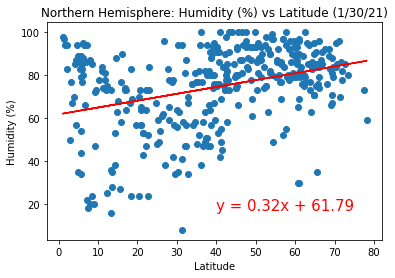

In [51]:
# This graph shows a weak positive relationship between latitude and humidity for cities in the northern hemisphere. As cities get closer to the equator they become more humid.
x_values = clean_city_data_north_df['Latitude']
y_values = clean_city_data_north_df['Humidity']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
plt.annotate(line_eq,(40,17),fontsize=15,color="red")
plt.title(f'Northern Hemisphere: Humidity (%) vs Latitude ({today_date})')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.22088076892610306


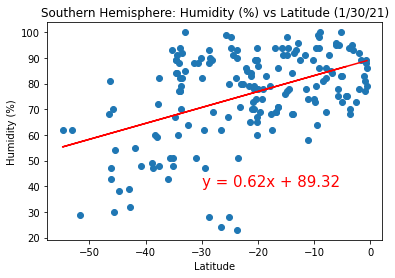

In [52]:
# This graph shows a weak positive relationship between humidity and latitude for cities in the southern hemisphere. As cities get closer to the equator, they become more humid 
x_values = clean_city_data_south_df['Latitude']
y_values = clean_city_data_south_df['Humidity']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
plt.annotate(line_eq,(-30,40),fontsize=15,color="red")
plt.title(f'Southern Hemisphere: Humidity (%) vs Latitude ({today_date})')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.0687521570645846


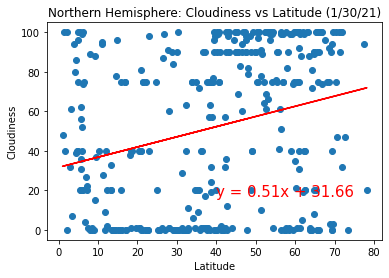

In [53]:
# A very week relationship between cloud cover and latitude. As cities become further from the equater, they have more clouds.
x_values = clean_city_data_north_df['Latitude']
y_values = clean_city_data_north_df['Cloudiness']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
plt.annotate(line_eq,(40,17),fontsize=15,color="red")
plt.title(f'Northern Hemisphere: Cloudiness vs Latitude ({today_date})')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.15752419333128248


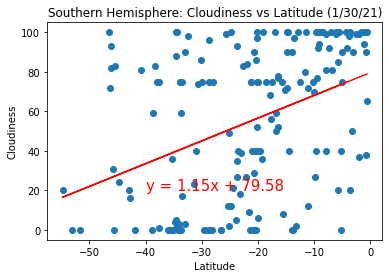

In [67]:
# The opposite is true for the southern hemisphere. More southerly cities have less cloud. 
x_values = clean_city_data_south_df['Latitude']
y_values = clean_city_data_south_df['Cloudiness']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
plt.annotate(line_eq,(-40,20),fontsize=15,color="red")
plt.title(f'Southern Hemisphere: Cloudiness vs Latitude ({today_date})')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.0038666148503884593


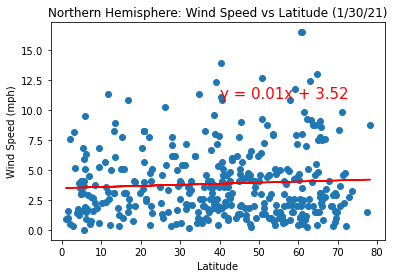

In [55]:
#Very little relationship between wind speed and latitude in the northern hemisphere. 

x_values = clean_city_data_north_df['Latitude']
y_values = clean_city_data_north_df['Wind Speed']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
plt.annotate(line_eq,(40,11),fontsize=15,color="red")
plt.title(f'Northern Hemisphere: Wind Speed vs Latitude ({today_date})')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.01897197226872158


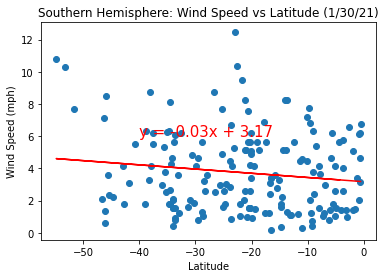

In [56]:
# A weak negative relationship between wind speed and latitude in the southern hemisphere. 

x_values = clean_city_data_south_df['Latitude']
y_values = clean_city_data_south_df['Wind Speed']
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)    # Perform linear regression
regress_values = x_values * slope + intercept                                        # Get x/y values for linear regression linear
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")                                               # Add linear regression line to plot
plt.annotate(line_eq,(-40,6),fontsize=15,color="red")
plt.title(f'Southern Hemisphere: Wind Speed vs Latitude ({today_date})')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
print(f"The r-squared is: {rvalue**2}")
plt.show()